In [88]:
from simple_unet_model import simple_unet_model
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import random

In [43]:
minmaxscaler = MinMaxScaler()

In [120]:
image_patch_size = 256

def crop_to_nearest_patch_multiples(image_shape, image_patch_size=256):
    new_width = (image_shape[1] // image_patch_size) * image_patch_size
    new_height = (image_shape[0] // image_patch_size) * image_patch_size
    return new_width, new_height

image_dataset = []
mask_dataset = []

image_folder = 'dataset/images'
mask_folder = 'dataset/masks'

for image_filename in os.listdir(image_folder):
    if image_filename.endswith('.jpeg'):
        mask_filename = image_filename.replace('.jpeg', '.png')
        # Construct full paths for the image and the corresponding mask
        image_path = os.path.join(image_folder, image_filename)
        mask_path = os.path.join(mask_folder, mask_filename)
        # Read the image and mask
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is not None and mask is not None:
            # Crop the image and mask to the nearest patch size multiples
            new_width, new_height = crop_to_nearest_patch_multiples(image.shape)
            image = Image.fromarray(image)
            mask = Image.fromarray(mask)

            image = image.crop((0, 0, new_width, new_height))
            mask = mask.crop((0, 0, new_width, new_height))

            image = np.array(image)
            mask = np.array(mask)

            # Patchify the image and mask
            patched_images = patchify(image, (image_patch_size, image_patch_size), step=image_patch_size)
            patched_masks = patchify(mask, (image_patch_size, image_patch_size), step=image_patch_size)

            # Append patches to dataset
            for i in range(patched_images.shape[0]):
                for j in range(patched_images.shape[1]):
                    individual_patched_image = patched_images[i, j, :, :]
                    individual_patched_mask = patched_masks[i, j, :, :]         

                    # Normalize the image patch
                    individual_patched_image = minmaxscaler.fit_transform(
                        individual_patched_image.reshape(-1, individual_patched_image.shape[-1])
                    ).reshape(individual_patched_image.shape)

                    image_dataset.append(individual_patched_image)
                    mask_dataset.append(individual_patched_mask)

In [121]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [122]:
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [123]:
print(image_dataset.shape)
print(mask_dataset.shape)

(626, 256, 256, 1)
(626, 256, 256, 1)


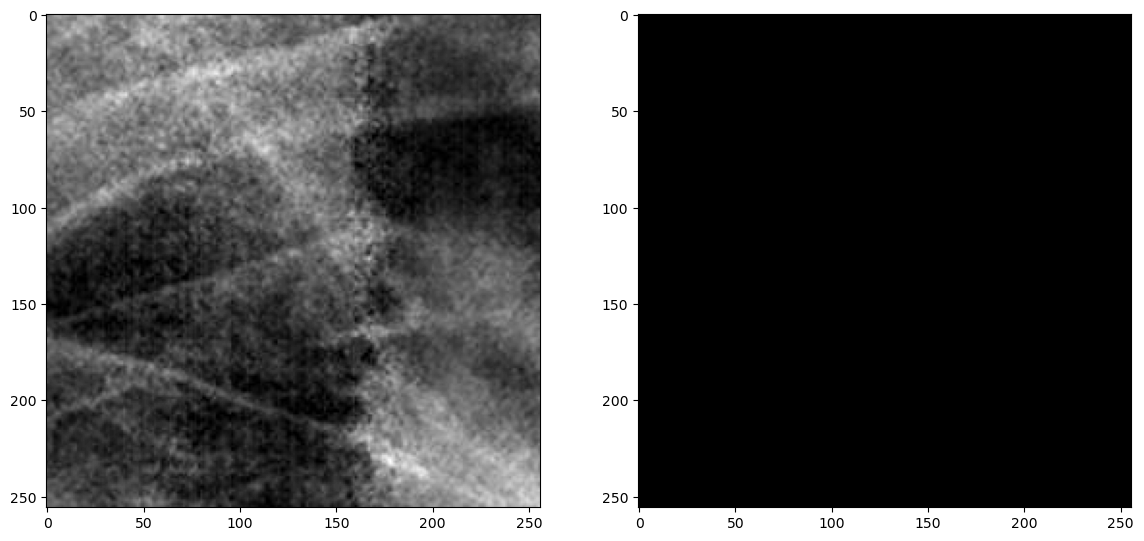

In [124]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id], cmap="gray")
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id], cmap="gray")

In [125]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.25, random_state = 0)

In [50]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(469, 256, 256, 1)
(157, 256, 256, 1)
(469, 256, 256, 1)
(157, 256, 256, 1)


In [51]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]

In [52]:
def get_model():
    return simple_unet_model(image_height, image_width, image_channels)

model = get_model()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 256, 256,  │          0 │ conv2d_57[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_27[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ conv2d_58[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 128, 128,  │          0 │ conv2d_59[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_28[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ conv2d_60[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 64, 64,    │          0 │ conv2d_61[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_29[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 32, 32,    │          0 │ conv2d_62[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 32, 32,    │          0 │ conv2d_63[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_30[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 16, 16,    │          0 │ conv2d_64[0][0] 

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

model.save('lungs_seg.hdf5')

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 441ms/step - accuracy: 0.5329 - loss: 0.6917 - val_accuracy: 0.5823 - val_loss: 0.6795
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.5406 - loss: 0.6820 - val_accuracy: 0.5846 - val_loss: 0.6596
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.5563 - loss: 0.6570 - val_accuracy: 0.5539 - val_loss: 0.6884
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.5324 - loss: 0.6898 - val_accuracy: 0.5560 - val_loss: 0.6884
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.5357 - loss: 0.6883 - val_accuracy: 0.5189 - val_loss: 0.6844
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.5511 - loss: 0.6772 - val_accuracy: 0.5868 - val_loss: 0.6654
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.5737 - loss: 0.7448 - val_accuracy: 0.5103 - val_loss: 0.6868
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.5524 - loss: 0.7256 - val_acc

In [54]:
# evaluate model
loss, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")
print("Error = ", loss)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.8213 - loss: 1.0128
Accuracy =  82.50076174736023 %
Error =  0.9961497187614441


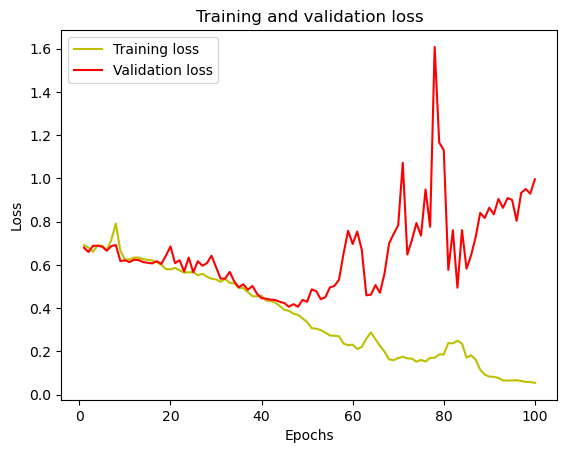

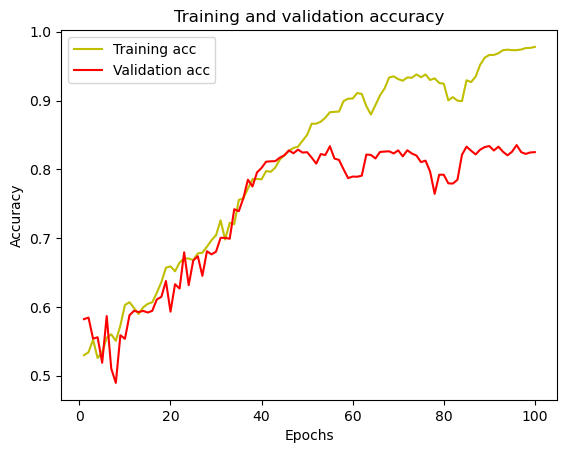

In [55]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [60]:
#IOU
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
IoU socre is:  0.6803409333460614


In [134]:
normalized_patched_images = []

image = cv2.imread('test_images/NORMAL2-IM-0145-0001.jpeg', 0)
image = np.array(image)

patched_images = patchify(image, (image_patch_size, image_patch_size), step=image_patch_size)
print(patched_images.shape)
# patched_images = patched_images[:,:,0,:,:,:]

for i in range(patched_images.shape[0]):
    for j in range(patched_images.shape[1]):
        individual_patched_image = patched_images[i, j, :, :]
        individual_patched_image = minmaxscaler.fit_transform(
                        individual_patched_image.reshape(-1, individual_patched_image.shape[-1])
                    ).reshape(individual_patched_image.shape)
        normalized_patched_images.append(individual_patched_image)

(5, 6, 256, 256)


  0%|          | 0/8 [00:00<?, ?it/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 12%|█▎        | 1/8 [00:02<00:18,  2.59s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 25%|██▌       | 2/8 [00:05<00:15,  2.54s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 38%|███▊      | 3/8 [00:07<00:12,  2.51s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 50%|█████     | 4/8 [00:09<00:09,  2.47s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 62%|██████▎   | 5/8 [00:12<00:07,  2.45s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 75%|███████▌  | 6/8 [00:14<00:04,  2.43s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 88%|████████▊ | 7/8 [00:17<00:02,  2.41s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


100%|██████████| 8/8 [00:19<00:00,  2.45s/it]


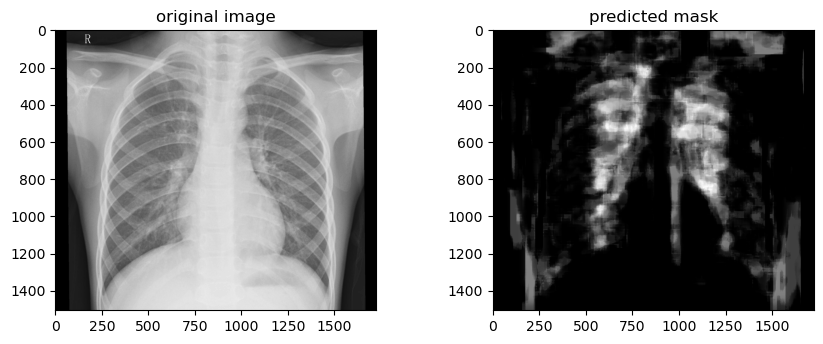

In [113]:
# Reconstruct and predict image using smooth blending
from smooth_tiled_predictions import predict_img_with_smooth_windowing

input_img = minmaxscaler.fit_transform(
                        image.reshape(-1, image.shape[-1])
                    ).reshape(image.shape)

input_img = np.expand_dims(input_img,2)

predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=image_patch_size,
    subdivisions=2,
    nb_classes=1,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)

# final_prediction = (predictions_smooth>0.4).astype(np.uint8)
final_prediction = (predictions_smooth * 255).astype(np.uint8)

# Visualization
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('original image')
plt.imshow(image, cmap="gray")
plt.subplot(232)
plt.title('predicted mask')
plt.imshow(final_prediction, cmap="gray")
plt.show()

(30, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


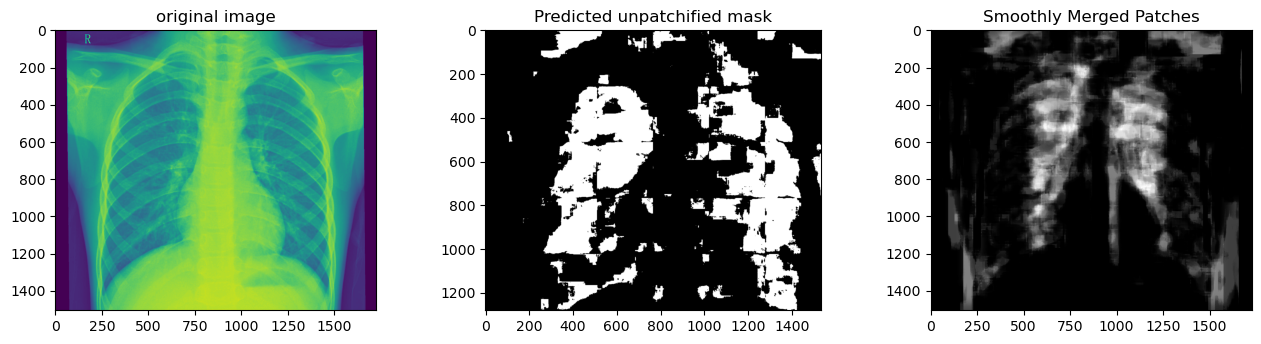

In [135]:
# Reconstruct image using unpatchify

normalized_patched_images = np.array(normalized_patched_images)
print(normalized_patched_images.shape)

# normalized_patched_images = np.expand_dims(normalized_patched_images,3)

prediction = model.predict(normalized_patched_images)
prediction = (prediction>0.5)
prediction = (prediction * 255).astype(np.uint8)

expected_shape = (patched_images.shape[0], patched_images.shape[1], patched_images.shape[2], patched_images.shape[3])

patched_prediction = np.reshape(prediction, expected_shape)

unpatched_prediction = unpatchify(patched_prediction, (patched_images.shape[0] * 256, patched_images.shape[1] * 256))

# Visualization
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('original image')
plt.imshow(image)
plt.subplot(232)
plt.title('Predicted unpatchified mask')
plt.imshow(cv2.cvtColor(unpatched_prediction, cv2.COLOR_BGR2RGB))
plt.subplot(233)
plt.title('Smoothly Merged Patches')
plt.imshow(final_prediction, cmap='gray')
plt.show()